In [270]:
import numpy as np
import matplotlib.pyplot as pl
from pathlib import Path
import norm
import physconst as pc
from vtk_reader import read_vtk
import ffmpeg as fp

In [271]:
data_dir = Path('/Users/satoukakeru/lab/Jet_Torus/runs')
run_ids = ['00a2']

In [272]:
data_fbase = 'data'
data_type = 'flt'
nc = 128
ndata = [range(0, 2)]
grid = [nc, nc, nc]
nvar = 7
x1_min, x1_max = -5., 5.  # code units
x2_min, x2_max = -5., 5.  # code units
x3_min, x3_max = -5., 5.  # code units
dx1 = (x1_max - x1_min) / grid[0]
dx2 = (x2_max - x2_min) / grid[1]
dx3 = (x3_max - x3_min) / grid[2]
cell_volume = dx1 * dx2 * dx3

nm = norm.PhysNorm(x=pc.pc, v=pc.c, dens=0.60364*pc.amu, temp=pc.c*pc.c*pc.amu/pc.kboltz, curr=1.)
fnum2year = nm.t / pc.yr * 24.5009005929988

In [273]:
x1 = np.linspace(x1_min, x1_max, nc)
x2 = np.linspace(x2_min, x2_max, nc)
x3 = np.linspace(x3_min, x3_max, nc)

/var/folders/ww/rzgcz9mj4d3fzmgml3jvp3dh0000gn/T/ipykernel_55595/2998639481.py:47: RuntimeWarning: divide by zero encountered in log10
  lfreq = np.log10(freq)
/var/folders/ww/rzgcz9mj4d3fzmgml3jvp3dh0000gn/T/ipykernel_55595/2998639481.py:47: RuntimeWarning: invalid value encountered in log10
  lfreq = np.log10(freq)
/var/folders/ww/rzgcz9mj4d3fzmgml3jvp3dh0000gn/T/ipykernel_55595/2998639481.py:47: RuntimeWarning: divide by zero encountered in log10
  lfreq = np.log10(freq)
/var/folders/ww/rzgcz9mj4d3fzmgml3jvp3dh0000gn/T/ipykernel_55595/2998639481.py:47: RuntimeWarning: invalid value encountered in log10
  lfreq = np.log10(freq)


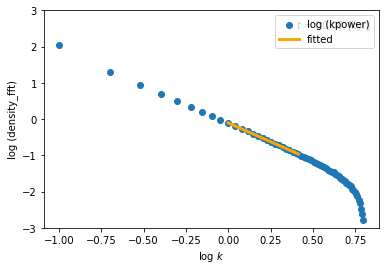

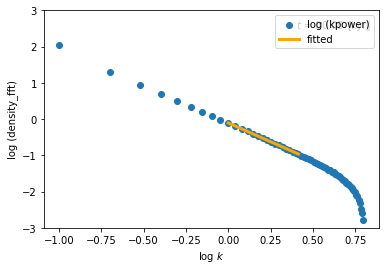

In [274]:
for ir, run_id in enumerate(run_ids):
    slope = []
    for idata in ndata[ir]:
        data_fname = data_dir / run_id / f'{data_fbase}.{idata:0>4d}.{data_type}'

        if data_type == 'flt':
            hydro = np.fromfile(data_fname, dtype=np.float32).reshape((nvar, grid[2], grid[1], grid[0]))
            density = hydro[0, :, :, :]

        elif data_type == 'vtk':
            with open(data_fname, 'rb') as fp:
                hydro = read_vtk(fp, grid[0], grid[1], grid[2])

        time = np.arange(idata+1) * fnum2year
        time_diff = np.diff(time)

        # 密度のfftの３次元arrayを１次元arrayに変換する。

        kpower = np.fft.fftn(density)

        kpower_2 = np.sum(kpower, axis=2)
        kpower_21 = np.sum(kpower_2, axis=1)
        kpower0 = np.abs(kpower_21)

        kpower_0 = np.sum(kpower, axis=0)
        kpower_01 = np.sum(kpower_0, axis=1)
        kpower1 = np.abs(kpower_01)

        kpower_00 = np.sum(kpower_0, axis=0)
        kpower2 = np.abs(kpower_00)

        kpower1dim = (kpower0 + kpower1 + kpower2) / 3

        # 波数を定義する。

        freq = np.fft.fftfreq(nc, d=dx1)

        # 波数と密度fftの両対数グラフをプロットする。

        pl.figure()
        pl.ylim(-3, 3)
        pl.xlabel(r'log $k$')
        pl.ylabel(r'log (density_fft)')
        pl.text(0.4, 2.5, f'$t$ = {time[idata] / 1000 :05.2f}')
        pl.text(0.7, 2.5, '[kyr]')

        lfreq = np.log10(freq)
        lpow = np.log10(kpower1dim)
        pl.scatter(lfreq, lpow, label=f'log (kpower)')
        #pl.savefig(f'density_fft{idata:04d}.jpeg', dpi=300)

        #　フィッティングする範囲を決めて、最小二乗法を用いて一次関数でフィッティングする。

        s_fit = np.s_[10:27]

        pf = np.polyfit(lfreq[s_fit], lpow[s_fit], 1)
        pol = np.poly1d(pf)

        pl.plot(lfreq[s_fit], pol(lfreq[s_fit]), lw=3, c='orange', label='fitted')
        pl.legend()

        # 時間ごとのフィッティング関数の傾きのリストを作る。

        slope.append(pf[0])

Text(0, 0.5, 'exponents of power spectrum')

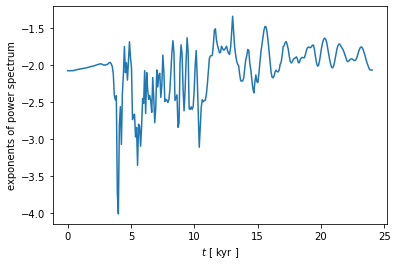

In [205]:
pl.plot(time / 1000, slope)

pl.xlabel(r'$t$ [ kyr ]')
pl.ylabel(r'exponents of power spectrum')

In [266]:
stream = fp.input("./images of density_fft/density_fft%04d.jpeg")
stream = fp.output(stream, "movie_fft.mp4")
fp.run(stream)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/Users/satoukakeru/opt/anaconda3 --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from './ima

(None, None)